# Working with Sequence Data using RNNs

## Setup

In [ ]:
! wget https://github.com/townie/PTB-dataset-from-Tomas-Mikolov-s-webpage/raw/master/data/ptb.train.txt
! wget https://github.com/townie/PTB-dataset-from-Tomas-Mikolov-s-webpage/raw/master/data/ptb.valid.txt
! wget https://github.com/townie/PTB-dataset-from-Tomas-Mikolov-s-webpage/raw/master/data/ptb.test.txt

! sed -e 's/<unk>//g' ptb.train.txt > ptb.train.nounk.txt
! sed -e 's/<unk>//g' ptb.valid.txt > ptb.valid.nounk.txt
! sed -e 's/<unk>//g' ptb.test.txt > ptb.test.nounk.txt

## RNNCell vs RNN

Recurrent Neural Networks (RNNs) are a little unique because they are a recurrent neural network module: they get reused multiple times in a single forward pass over different time steps. Because of this, there are two implementations of the same core logic in torch:

1. `RNNCell` which is a basic implementation that runs for a single time step
2. `RNN` which includes additional components such as multiple layers, and potentially having a more efficient CUDA implementation as well.

(You will see a similar convention for other RNN models, e.g. `LSTMCell` and `LSTM`.)

You will likely primarily use the `RNN` implementation, but it is worth understanding how the two interact.

### Full Explanation (Optional)

<img src="https://i.stack.imgur.com/SjnTl.png" style="width:80%">


We can start by breaking down what `RNNCell` and `RNN` are.

To recap, we expect an `RNNCell` to take in two inputs (a) the input for that time step, $x_t$, and (b) the current hidden state $h_t$, and outputs $h_{t+1}$, the hidden state for the next time step.

(Note: the $t$ notation may differ across materials, but generally they refer to the same thing.)

$$ h_{t+1} = \text{RNNCell}(x_t, h_t) $$

An `RNN` primarily incorporates two additional things:

1. Processing across time steps
2. Processing across layers

Let us first consider a single layer `RNN`. We can describe it as the following:

\begin{align}
  \text{Output}, \text{FinalHiddenState} &= \text{RNN}(
    [x_{0} \cdots x_{T}],
    h_{0}
  ) \\
  \text{where} \\
  \text{Output} &= [h_{1} \cdots h_{T+1}] \\
  \text{FinalHiddenStates} &= [h_{T+1}]
\end{align}

You will need to provide the whole time sequence of $x_t$ at once, but you only need to provide $h_0$. The `RNN` implementation will automatically feed the resulting $h_1$ back into the model as input for the next time step, and repeat until it is done computing the whole sequence.

`RNN` actually returns two outputs. One for the "output" of the RNN, and another only consisting of the final hidden state. This may seem redundant, but makes sense when we consider a multi-layer RNN.

Let us modify the notation slightly. Let $h_{t,l}$ refer to the hidden state at time step $t$ and layer $l$. Let's assume as have layers going from $0$ to $L$.Hence, we have as inputs $x_t$ and $h_{0, 0}$. Then, `RNN` does the following:

\begin{align}
  \text{Output}, \text{FinalHiddenState} &= \text{RNN}(
    [x_{0} \cdots x_{T}],
    h_{0,0}
  ) \\
  \text{where} \\
  \text{Output} &= [h_{1,L} \cdots h_{T+1, L}] \\
  \text{FinalHiddenStates} &= [h_{T+1,0} \cdots h_{T+1,L}]
\end{align}

Now we see the difference: "Output" contains the hidden states for the final layer for all time steps, while "FinalHiddenState" contains the hidden states for the final time step for each layer.

Now, let's see this in code.

First, let's do some setup. We'll define some hyperparameters, and define `rnn_cell` and `rnn`.

**Note**: Because of the way RNNs are computed by iterating over the time steps, it is actually more efficient to have time be the first dimension of the input, rather than the batch size. For simplicity, we are going to use the slightly more inefficient version, keeping batch size first, and using the `batch_first=True` argument when creating our `RNN`. If you want to switch over, be sure to update both the `RNN` initialization arguments as well as the input shapes (which can be modified via a simple transpose).

### Code `RNNCell` vs `RNN`

In [ ]:
import itertools
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import trange, tqdm

In [ ]:
# Hyperparameters and setup
rng = np.random.default_rng(1111)
batch_size = 2
seq_len = 10
hidden_dim = 4
input_dim = 8

# Create our RNN implementations
rnn_cell = nn.RNNCell(
    input_size=input_dim, 
    hidden_size=hidden_dim,
    nonlinearity="tanh",
)
rnn = nn.RNN(
    input_size=input_dim, 
    hidden_size=hidden_dim,
    nonlinearity="tanh",
    num_layers=1,
    batch_first=True,  # <-- Note this!
)

# Initialize some inputs
inputs = torch.from_numpy(rng.random(
    size=(batch_size, seq_len, input_dim),
)).float()
initial_hidden_state = torch.from_numpy(rng.random(
    size=(batch_size, hidden_dim),
)).float()

We can see that they have identified parameters (albeit with different names).

In [ ]:
print("RNNCell parameters")
for name, params in rnn_cell.named_parameters():
    print(name, tuple(params.shape))

print()
print("RNN parameters")
for name, params in rnn.named_parameters():
    print(name, tuple(params.shape))

Because we want to directly compare the two implementations, we want to ensure that they have the same weights. Let's do that be assigning them to be the same.

In [ ]:
# Set to the exact same weights
rnn.weight_ih_l0 = rnn_cell.weight_ih
rnn.weight_hh_l0 = rnn_cell.weight_hh
rnn.bias_ih_l0 = rnn_cell.bias_ih
rnn.bias_hh_l0 = rnn_cell.bias_hh

Let's do the RNNCell forward pass first. We supply $x_t$ and $h_t$ at each time step, iterating over time manually with a loop.

In [ ]:
# RNNCell forward pass
with torch.no_grad():
    hidden_state = initial_hidden_state
    for time_step in range(seq_len):
        hidden_state = rnn_cell(
            inputs[:, time_step],
            hidden_state,
        )
    rnn_cell_final_hidden_state = hidden_state

Let's do the equivalent for `RNN`, where we supply `[x_0 \cdots x_T]` and `h_0`. The corresponding outputs are computed all at once. 

In [ ]:
# RNN forward pass
with torch.no_grad():
    rnn_out, rnn_final_hidden_states = rnn(
        inputs,
        initial_hidden_state.unsqueeze(0),  # <-- add a [1] dimension, corresponding to the layer
    )

Now, let's look at the dimensions of our output tensors.

In [ ]:
# RNNCell final hidden state: [batch_size, hidden_dim]
print(rnn_cell_final_hidden_state.shape)

# RNN final output: [batch_size, seq_len, hidden_dim]
print(rnn_out.shape)

# RNN final hidden states: [num_layers, batch_size, hidden_dim]
print(rnn_final_hidden_states.shape)

We see that we get the same results with a manual loop over `RNNCell`, or with an `RNN`.

In [ ]:
# RNN final output is the last hidden state of the last layer of the RNN
assert torch.allclose(
    rnn_out[:, -1],
    rnn_final_hidden_states[0],
)

# RNNCell final hidden state is the last hidden state of the last layer of the RNN
assert torch.allclose(
    rnn_cell_final_hidden_state,
    rnn_out[:, -1],
)
assert torch.allclose(
    rnn_cell_final_hidden_state,
    rnn_final_hidden_states[0],
)

In short, `RNN` provides a much more convenient (and potentially more efficient) implementation of using `RNNCell`. We covered the single layer example, but you can see how it will be even more convenient for multi-layer RNNs.

## Training an RNN-LM

In this section, we will train an RNN language model.

Our preprocessing is quite similar to what we did in the previous lab. The highlights are:

1. Creating a vocabulary based on the training set
2. Adding the `<pad>` (id=0) and `<unk>` (id=1) tokens to our vocabulary



In [ ]:
import itertools
import joblib
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import trange, tqdm

In [ ]:
# We can use the unk versions actually, but for fair comparison we won't
TRAIN_PATH = "ptb.train.nounk.txt"
VAL_PATH = "ptb.valid.nounk.txt"
TEST_PATH = "ptb.test.nounk.txt"
PAD = "<pad>"
PAD_IDX = 0
UNK = "<unk>"
UNK_IDX = 1
BATCH_SIZE = 128
MAX_SEQ_LENGTH = 300
DEVICE = torch.device("cuda:0")

In [ ]:
def load_tokens(path):
    """Read file and generate list of list of tokens.""" 
    with open(path, "r") as f:
        tokens_list = []
        for line in f:
            line = line.strip()
            if not line: 
                continue
            tokens_list.append(["<bos>"] + line.split() + ["<eos>"])
    return tokens_list

def get_tokenized_arr(tokens_list, tok2idx):
    """Convert list of list of tokens to list of list of token IDs, with UNK replacement."""
    example_rows = []
    for tokens in tokens_list:
        row = [tok2idx.get(token, tok2idx[UNK]) for token in tokens]
        example_rows.append(row)
    return example_rows

For our `LMDataset`, we will actually make things simple, returning just the array of (truncated and padded) token IDs. We do not distinguish between input and labels yet. We will see why shortly.

In [ ]:
class LMDataset(Dataset):
   
    def __init__(self, tokenized_arr, max_seq_length=MAX_SEQ_LENGTH):
        self.tokenized_arr = tokenized_arr
        self.max_seq_length = max_seq_length

    def __len__(self):
        return len(self.tokenized_arr)
        
    def __getitem__(self, key):
        # Truncate to max_seq_length
        x = self.tokenized_arr[key][:self.max_seq_length]

        # Pad
        arr = np.pad(x, (0, self.max_seq_length - len(x)), constant_values=PAD_IDX)
        assert len(arr) == self.max_seq_length
        return {
            "arr": arr,
        }

Our data pipeline should be straightforward and resemble what we have seen before.

In [ ]:
# Load raw token data
train_tokens = load_tokens(TRAIN_PATH)
val_tokens = load_tokens(VAL_PATH)
test_tokens = load_tokens(TEST_PATH)

# Build vocab
vocab = [PAD] + [UNK] + sorted(list({
    token 
    for token_line in train_tokens 
    for token in token_line
    if token != UNK
}))
tok2idx = {vocab: i for i, vocab in enumerate(vocab)}
idx2tok = dict(enumerate(vocab))

# Create raw data arrays
train_arr = get_tokenized_arr(train_tokens, tok2idx)
val_arr = get_tokenized_arr(val_tokens, tok2idx)
test_arr = get_tokenized_arr(test_tokens, tok2idx)

# Create datasets
train_dataset = LMDataset(train_arr)
val_dataset = LMDataset(val_arr)
test_dataset = LMDataset(test_arr)

# Create dataloaders
train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
)
val_dataloader = DataLoader(
    dataset=val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
)
test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
)

Now, given a batch from our dataloader, we will write a function to create our inputs and labels.

Remember that for model, we want to tackle the following prediction problem:



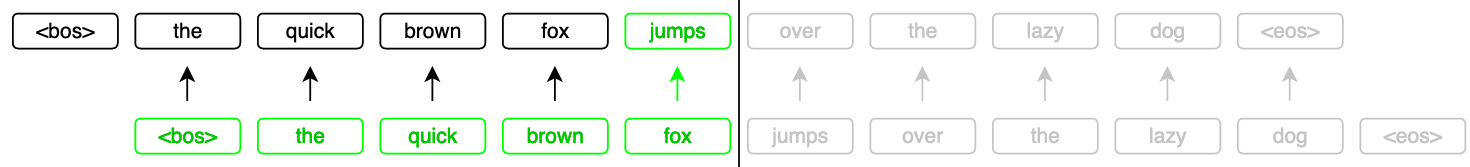

We see that language modeling has a nice property where the labels are simply a 1-shifted version of our input. As long as we ensure that the model has no way of cheating and making use of future labels, it will not be an issue.

In the case of RNNs, there is no cheating because the inputs are processed sequentially. We will see in the case of later models like Transformers that we will need special handling to prevent this.

In [ ]:
def format_batch(batch):
    """Take a batch from the dataloader and create inputs for our models/training."""
    arr = batch["arr"].to(DEVICE)
    return {
        # Input: Drop last token
        "inputs": arr[:, :-1],
        # Label: Drop first token
        "labels": arr[:, 1:],
    }

Now, let's make define our model.

In [ ]:
class RNNModel(nn.Module):
    def __init__(self, vocab_size, emb_dim, num_layers, dropout_p=0.5):
        super().__init__()
        self.emb_dim = emb_dim
        self.in_embed = nn.Embedding(vocab_size, emb_dim)
        self.rnn = nn.RNN(
            input_size=emb_dim,
            hidden_size=emb_dim,
            num_layers=num_layers,
            nonlinearity="tanh",
            batch_first=True,
        )
        self.dropout = nn.Dropout(dropout_p)
        self.out_embed = nn.Linear(emb_dim, vocab_size)

        # Share weights between embeddings
        self.out_embed.weight = self.in_embed.weight
    
    def forward(self, x):
        out = self.in_embed(x)
        # h_0 is all zeros if it is not provided
        out, hidden = self.rnn(out)
        out = self.out_embed(self.dropout(out))
        return out

We will also write our evaluation loop and train step implementations similar to before. In language modeling, it is more common to think in terms of training steps rather than training epochs, since often we have abundant amounts of training data. In some cases, some big models never even finish 1 epoch of training!

**Important**: Pay close attention how how the cross entropy loss function is used. As discussed before, we can either use a `nn.CrossEntropyLoss` object or a `F.cross_entropy` function. Let's focus on this part from `train_step`:

```python
flattened_logits = logits.reshape(-1, len(vocab))
flattened_labels = batch["labels"].reshape(-1)
loss = F.cross_entropy(
    flattened_logits,
    flattened_labels,
    reduction='mean',
    ignore_index=PAD_IDX,  # <-- This is important!
)
```

First, we see that we do some reshaping of the logits and labels. Remember that the logits should have shape `[bs, seq_len, vocab]` while labels have shape `[bs, seq_len]`. Because `F.cross_entropy` expects logits of shape `[N, classes]` and `[N]`, we flatten the first two dimensions of both logits and labels.

Secondly, note that we have `ignore_index=PAD_IDX`. Remember that we have padded all of our inputs to be of the same length. If we do not add this `ignore_index` here, our loss function will also compute losses against the padding tokens! By supplying this argument, the `F.cross_entropy` function will ignore all examples where the label ID is `PAD_IDX`. When it computes the mean loss over all tokens, it will also take that into consideration for the denominator.

You can also see it as doing the following:

```python
raw_loss = F.cross_entropy(
    flattened_logits,
    flattened_labels,
    reduction='none',
)
is_valid = (flattened_labels != PAD_IDX).bool()
loss = raw_loss[is_valid].sum() / is_valid.sum()
```

You will see in our `eval_loop` that we have a slightly more complex handling because we also want to compute our per-token accuracy. (In practice, token accuracy is not often used to measure language model performance, but it is a good exercise to see what we do to handle it.)

In [ ]:
@torch.no_grad()
def eval_loop(model, dataloader, num_batches=None):
    """Run validation phase."""
    model.eval()

    # Keeping track of metrics
    total_loss = 0.0
    total_correct = 0.0
    total_count = 0

    if num_batches is None:
        num_batches = len(dataloader)
    for raw_batch in tqdm(dataloader, desc="Val", total=num_batches):
        batch = format_batch(raw_batch)
        logits = model(batch["inputs"])
        flattened_logits = logits.reshape(-1, len(vocab))
        flattened_labels = batch["labels"].reshape(-1)
        loss = F.cross_entropy(
            flattened_logits,
            flattened_labels,
            reduction='sum',
            ignore_index=PAD_IDX,  # <-- This is important!
        )

        # Only count non-padding tokens
        # (Same idea as ignore_index=PAD_IDX above)
        valid_indices = flattened_labels != PAD_IDX
        valid_count = valid_indices.sum().item()
        preds = flattened_logits.argmax(-1)
        raw_correct_preds = (preds == flattened_labels)
        correct_preds = (raw_correct_preds & valid_indices).sum()

        # Keeping track of metrics
        total_loss += loss.item()
        total_correct += correct_preds.item()
        total_count += valid_count
    return {
        "loss": total_loss / total_count,
        "acc": total_correct / total_count,
    }

def train_step(optimizer, model, raw_batch):
    """Run a single train step."""
    model.train()
    optimizer.zero_grad()
    batch = format_batch(raw_batch)
    logits = model(batch["inputs"])
    flattened_logits = logits.reshape(-1, len(vocab))
    flattened_labels = batch["labels"].reshape(-1)
    loss = F.cross_entropy(
        flattened_logits,
        flattened_labels,
        reduction='mean',
        ignore_index=PAD_IDX,  # <-- This is important!
    )
    loss.backward()
    optimizer.step()
    return loss.item()

Instead of accuracy, we often use perplexity to measure the performance of language models. Perplexity is defined as

$$ \text{PPL}(x) = \exp \left(-\frac{1}{\sum_{n=1}^NT^n}\sum_{n=1}^T \sum_{t=1}^{T^n} \log p(w_t^n | w^n_{<t})\right)$$

Remember that our loss corresponds to the (average) negative loglikelihood of our data (over all sequences in the corpus). You should then be able to see that perplexity is simply the exponentiaion of our cross entropy loss.

An "intuitive" interpretation of perplexity is, if for each token you were to line up all your model token predictions from most to least likely and go down the list until you get the correct token, how far down on the list you would have to go *on average*.

Also take a look at https://huggingface.co/transformers/perplexity.html for more details about evaluating perplexity with language models.

In [ ]:
def compute_perplexity(loss_val):
    return np.exp(loss_val)

Now that all our pieces are in place, let's start training!

In [ ]:
rnn_model = RNNModel(vocab_size=len(vocab), num_layers=4, emb_dim=200).to(DEVICE)
optimizer = optim.AdamW(rnn_model.parameters(), lr=1e-3)

In [ ]:
NUM_EPOCHS = 20
total_steps = NUM_EPOCHS * len(train_dataloader)
train_loss_list = []
for step, raw_batch in zip(range(total_steps), itertools.cycle(train_dataloader)):
    loss_val = train_step(
        optimizer=optimizer,
        model=rnn_model,
        raw_batch=raw_batch,
    )
    train_loss_list.append(loss_val)
    if step % 100 == 0 and step != 0:
        val_results = eval_loop(
            model=rnn_model,
            dataloader=val_dataloader,
        )
        print("Step: {}/{}, train perp: {:.1f}, val perp: {:.1f}, acc: {:.3f}".format(
            step, 
            total_steps,
            compute_perplexity(np.mean(train_loss_list)),
            compute_perplexity(val_results["loss"]),
            val_results["acc"])
        )
        train_loss = []

## Comparison between LMs

We have now considered three kinds of language models:

- Count-based N-gram model
- Feed-forward N-gram model
- RNN model

We will use **perplexity** as our comparison metric.

To provide a fair comparison between the different models, we need to ensure that:

- We use the same vocabulary across all models
- Exactly the same tokens are evaluated (which means we need to handle padding identically in all cases)

### Count-based N-gram Model

In [ ]:
# Refer to Lab 3

import numpy as np

class Node:
    def __init__(self):
        self.count = 0
        self.child_nodes = {}

    def has_token(self, token):
        return token in self.child_nodes

    def create_child_node(self, token):
        self.child_nodes[token] = Node()

    def increment_count(self):
        self.count += 1
    
    def get_child_node(self, token):
        if token not in self.child_nodes:
            raise KeyError(f"'{token}' not found in child node")
        return self.child_nodes[token]
        

class NgramTrie:
    def __init__(self, n):
        self.n = n
        self.root_node = Node()
        self.vocab = set()
    
    def add_ngram(self, ngram):
        if len(ngram) > self.n:
            raise RuntimeError(f"This NgramTrie only supports up to {self.n}-grams")

        # Update vocabulary
        self.vocab.update(ngram)

        # Update Trie
        current_node = self.root_node
        current_node.increment_count()
        for token in ngram:
            if not current_node.has_token(token):
                current_node.create_child_node(token)
            current_node = current_node.get_child_node(token)
            current_node.increment_count()

In [ ]:
# We prepend 3 <pad> tokens to ensure our data is consistent with the RNN data
def get_ngram_dataset(tokens_list, tok2idx, n):
    ngrams_list = []
    for tokens in tokens_list:
        tokens = [PAD, PAD, PAD] + tokens
        sequence = [tok2idx.get(token, tok2idx[UNK]) for token in tokens]
        for i in range(len(sequence)-n+1):
            sequence = sequence[:MAX_SEQ_LENGTH]
            ngram = tuple(sequence[i:i+n])
            ngrams_list.append(ngram)
    return ngrams_list

# We apply add-1 smoothing to ensure we never assign 0 probability to a token, 
# or run into issues with unseen N-grams
def get_cbngram_cond_dist_add1_smoothing(trie, input_ngram):
    current_node = trie.root_node
    # ADD-1 SMOOTHING (initialize before for efficiency)
    child_counts = {
        token: 1
        for token in trie.vocab
    }

    try:
        # Traverse trie
        for token in input_ngram:
            current_node = current_node.get_child_node(token)
        # Get count for each child node
        for token, node in current_node.child_nodes.items():
            child_counts[token] += node.count
    except KeyError:
        # Unseen N-gram
        pass

    # Divide by total counts
    total_count = sum(child_counts.values())
    child_prob = {}
    for token, count in child_counts.items():
        child_prob[token] = count / total_count
    return child_prob

def get_cbngram_perplexity(trie, ngrams_list):
    log_prob_list = []
    for ngram in tqdm(ngrams_list):
        input_ngram, label = ngram[:-1], ngram[-1]
        cond_dist = get_cbngram_cond_dist_add1_smoothing(trie_4gram, input_ngram)
        log_prob = np.log(cond_dist[label])
        log_prob_list.append(log_prob)
    count_based_ngram_perplexity = np.exp(-np.mean(log_prob_list))
    return count_based_ngram_perplexity

def get_cbngram_perplexity_parallel(trie, ngrams_list, n_jobs=4):
    log_prob_list = []
    def func(trie, sub_ngram_list):
        sub_log_prob_list = []
        for ngram in sub_ngram_list:
            input_ngram, label = ngram[:-1], ngram[-1]
            cond_dist = get_cbngram_cond_dist_add1_smoothing(trie, input_ngram)
            log_prob = np.log(cond_dist[label])
            sub_log_prob_list.append(log_prob)
        return sub_log_prob_list
    # We break the ngram list into n_jobs sub-lists for parallel processing
    # This is faster than parallel processing over each item
    sub_ngrams_list_list = [ngrams_list[i::n_jobs] for i in range(n_jobs)]
    log_prob_list_list = joblib.Parallel(n_jobs=n_jobs)(
        joblib.delayed(func)(trie, sub_ngram_list)
        for sub_ngram_list in sub_ngrams_list_list
    )
    log_prob_list = sorted([
        log_prob 
        for sub_log_prob_list in log_prob_list_list
        for log_prob in sub_log_prob_list
    ])
    count_based_ngram_perplexity = np.exp(-np.mean(log_prob_list))
    return count_based_ngram_perplexity

In [ ]:
train_ngrams = get_ngram_dataset(train_tokens, tok2idx, n=4)
val_ngrams = get_ngram_dataset(val_tokens, tok2idx, n=4)
test_ngrams = get_ngram_dataset(test_tokens, tok2idx, n=4)

trie_4gram = NgramTrie(n=4)
for ngram in tqdm(train_ngrams):
    trie_4gram.add_ngram(ngram)

In [ ]:
# This takes a while
val_cbngram_perplexity = get_cbngram_perplexity(trie_4gram, val_ngrams)
print(f"Count-based 4-gram PPL: {val_cbngram_perplexity}")

### Feedforward N-gram Model

In [ ]:
# Refer to Lab 3

class NgramDataset(Dataset):
   
    def __init__(self, tokenized_arr):
        self.tokenized_arr = tokenized_arr

    def __len__(self):
        return self.tokenized_arr.shape[0]
        
    def __getitem__(self, key):
        return self.tokenized_arr[key, :-1], self.tokenized_arr[key, -1]

class NgramModel(nn.Module):
    def __init__(self, vocab_size, ngram_n, emb_dim):
        super().__init__()
        self.emb_dim = emb_dim
        self.in_embed = nn.Embedding(vocab_size, emb_dim)
        self.linear = nn.Linear(emb_dim * (ngram_n - 1), emb_dim)
        self.out_embed = nn.Linear(emb_dim, vocab_size)

        # Share weights between embeddings
        self.out_embed.weight = self.in_embed.weight
    
    def forward(self, x):
        batch_size, seq_len = x.shape
        out = self.in_embed(x)
        out = out.reshape(batch_size, seq_len * self.emb_dim)
        out = F.relu(self.linear(out))
        out = self.out_embed(out)
        return out

@torch.no_grad()
def ffngram_eval_loop(model, dataloader):
    loss_total = 0.0
    count = 0
    for batch_x, batch_y in tqdm(dataloader):
        batch_x, batch_y = batch_x.to(DEVICE), batch_y.to(DEVICE)
        preds = model(batch_x)
        loss_sum = F.cross_entropy(preds, batch_y, reduction='sum')
        loss_total += loss_sum.item()
        count += batch_x.shape[0]
    perplexity = np.exp(loss_total / count)
    return perplexity

In [ ]:
train_ffngram_dataset = NgramDataset(np.array(train_ngrams))
val_ffngram_dataset = NgramDataset(np.array(val_ngrams))
test_ffngram_dataset = NgramDataset(np.array(test_ngrams))

train_ffngram_dataloader = torch.utils.data.DataLoader(
    dataset=train_ffngram_dataset, 
    batch_size=8192,
    shuffle=True,
)
val_ffngram_dataloader = torch.utils.data.DataLoader(
    dataset=val_ffngram_dataset, 
    batch_size=8192,
)
test_ffngram_dataloader = torch.utils.data.DataLoader(
    dataset=test_ffngram_dataset, 
    batch_size=8192,
)

In [ ]:
ffngram_model = NgramModel(vocab_size=len(vocab), ngram_n=4, emb_dim=200).to(DEVICE)
ffngram_optimizer = torch.optim.Adam(ffngram_model.parameters(), lr=0.003)

In [ ]:
NUM_EPOCHS = 2
for epoch in range(NUM_EPOCHS):
    print(f"Epoch {epoch}")

    # Train
    for batch_x, batch_y in tqdm(train_ffngram_dataloader):
        batch_x, batch_y = batch_x.to(DEVICE), batch_y.to(DEVICE)
        ffngram_optimizer.zero_grad()
        preds = ffngram_model(batch_x)
        loss = F.cross_entropy(preds, batch_y)
        loss.backward()
        ffngram_optimizer.step()
    val_perplexity = ffngram_eval_loop(ffngram_model, val_ffngram_dataloader)
    print(f"Val perp: {val_perplexity}")

### KenLM N-gram Model

In [ ]:
! wget -O - https://kheafield.com/code/kenlm.tar.gz |tar xz
! mkdir /content/kenlm/build; cd /content/kenlm/build; cmake ..; make -j 4
! pip install https://github.com/kpu/kenlm/archive/master.zip

In [ ]:
for phase in ["train", "valid", "test"]:
    new_lines = []
    with open(f"ptb.{phase}.nounk.txt", "r") as f_in:
        for line in f_in:
            if not line:
                continue
            truncated_line = " ".join(line.strip().split()[:300])
            new_lines.append(truncated_line)
    with open(f"ptb.{phase}.truncated.txt", "w") as f_out:
        f_out.write("\n".join(new_lines))

In [ ]:
# 4-gram
!./kenlm/build/bin/lmplz -o 4 < ptb.train.truncated.txt > ptb_lm_4gram.arpa

In [ ]:
import kenlm
kenlm_model = kenlm.LanguageModel('ptb_lm_4gram.arpa')

In [ ]:
def compute_kenlm_perplexity_on_file(kenlm_model, path):
    numerator = 0.0
    denominator = 0.0
    with open(path, "r") as f:
        for line in f:
            numerator += -kenlm_model.score(line)
            denominator += len(line.split())
    return 10 ** (numerator / denominator)

In [ ]:
compute_kenlm_perplexity_on_file(kenlm_model, "ptb.valid.truncated.txt")

### Evaluate on our test set

In [ ]:
test_cbngram_perplexity = get_cbngram_perplexity(trie_4gram, test_ngrams)
test_ffngram_perplexity = ffngram_eval_loop(ffngram_model, test_ffngram_dataloader)
test_rnn_preplexity = compute_perplexity(eval_loop(
    model=rnn_model,
    dataloader=test_dataloader,
)["loss"])
test_kenlm_perplexity = compute_kenlm_perplexity_on_file(
    kenlm_model, "ptb.test.truncated.txt",
)

In [ ]:
print("Test Perplexities")
print()
print(f"Count-based 4-Gram:  {test_cbngram_perplexity}")
print(f"FF 4-Gram:           {test_ffngram_perplexity}")
print(f"KenLM 4-Gram:        {test_kenlm_perplexity}")
print(f"RNN-LM:              {test_rnn_preplexity}")